
This is an example of Extended Kalman Filter (EKF) in python

Recall the linear equations of the classical Kalman Filter

$\boldsymbol{x} = Fx$

$\boldsymbol{z} = Hx$

In the extended Kalman filter, the state transition and observation models need not be 
linear functions of the state but may instead be differentiable functions.

$\boldsymbol{x}_{k} = g(\boldsymbol{x}_{k-1}, \boldsymbol{u}_{k-1}) + \boldsymbol{w}_{k-1}$

$\boldsymbol{z}_{k} = h(\boldsymbol{x}_{k}) + \boldsymbol{v}_{k}$

Where $w_k$ and $v_k$ are the process and observation noises which are both assumed to be zero 
mean Multivariate Gaussian noises with covariance matrix $Q$ and $R$ respectively.

The function $g$ can be used to compute the predicted state from the previous estimate and 
similarly the function $h$ can be used to compute the predicted measurement from the predicted state. However, $g$ and $h$ cannot be applied to the covariance directly. 

We linearise $g(x,u)$ and $h(x)$ by taking the partial derivatives of each to evaluate $F$ and $H$ at the point $x_t$ and $u_t$. The partial derivative of a matrix is called the Jacobian. $F$ and $H$ can be calculated as:


$$
\begin{aligned}
\mathbf F 
&= {\frac{\partial{f(\mathbf x_t, \mathbf u_t)}}{\partial{\mathbf x}}}\biggr|_{{\mathbf x_t},{\mathbf u_t}} \\
\mathbf H &= \frac{\partial{h(\bar{\mathbf x}_t)}}{\partial{\bar{\mathbf x}}}\biggr|_{\bar{\mathbf x}_t} 
\end{aligned}
$$

This leads to the following equations for the EKF. The differences to the classical KF is highlighted in boxes

$$\begin{array}{l|l}
\text{linear Kalman filter} & \text{EKF} \\
\hline 
& \boxed{\mathbf F = {\frac{\partial{f(\mathbf x_t, \mathbf u_t)}}{\partial{\mathbf x}}}\biggr|_{{\mathbf x_t},{\mathbf u_t}}} \\
\mathbf{\bar x} = \mathbf{Fx} + \mathbf{Bu} & \boxed{\mathbf{\bar x} = f(\mathbf x, \mathbf u)}  \\
\mathbf{\bar P} = \mathbf{FPF}^\mathsf{T}+\mathbf Q  & \mathbf{\bar P} = \mathbf{FPF}^\mathsf{T}+\mathbf Q \\
\hline
& \boxed{\mathbf H = \frac{\partial{h(\bar{\mathbf x}_t)}}{\partial{\bar{\mathbf x}}}\biggr|_{\bar{\mathbf x}_t}} \\
\textbf{y} = \mathbf z - \mathbf{H \bar{x}} & \textbf{y} = \mathbf z - \boxed{h(\bar{x})}\\
\mathbf{K} = \mathbf{\bar{P}H}^\mathsf{T} (\mathbf{H\bar{P}H}^\mathsf{T} + \mathbf R)^{-1} & \mathbf{K} = \mathbf{\bar{P}H}^\mathsf{T} (\mathbf{H\bar{P}H}^\mathsf{T} + \mathbf R)^{-1} \\
\mathbf x=\mathbf{\bar{x}} +\mathbf{K\textbf{y}} & \mathbf x=\mathbf{\bar{x}} +\mathbf{K\textbf{y}} \\
\mathbf P= (\mathbf{I}-\mathbf{KH})\mathbf{\bar{P}} & \mathbf P= (\mathbf{I}-\mathbf{KH})\mathbf{\bar{P}}
\end{array}$$

At each time step, the Jacobian is evaluated with current predicted states. These matrices 
can be used in the Kalman filter equations. This process essentially linearizes the non-linear function around the current estimate.

All symbolic calculations are made with [Sympy](http://nbviewer.ipython.org/github/jrjohansson/scientific-python-lectures/blob/master/Lecture-5-Sympy.ipynb)


In [1]:
import numpy as np
%matplotlib inline
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from scipy.stats import norm
from sympy import Symbol, symbols, Matrix, sin, cos
from sympy import init_printing
init_printing(use_latex=True)

### Now our example is to track a vehicle from its coordinates (X,Y), Heading, Velocity and Yaw rate (gyroscope) from sensors


$$x_k= \left[ \matrix{ x \\ y \\ \psi \\ v \\ \dot\psi} \right] = \left[ \matrix{ \text{Position X} \\ \text{Position Y} \\ \text{Heading} \\ \text{Velocity} \\ \text{Yaw Rate}} \right]$$

In [2]:
numstates=5 # States
dt = 1.0 / 50.0 #sample rate of measurement is 50Hz
dtGPS = 1.0 / 10.0 #sample rate of GPS is 10HZ

In [3]:
# Dynamic function $g$: calculates how the state is evolving from one to the next step

vs, psis, dpsis, dts, xs, ys, lats, lons = symbols('v \psi \dot\psi T x y lat lon')

gs = Matrix([[xs+(vs/dpsis)*(sin(psis+dpsis*dts)-sin(psis))],
             [ys+(vs/dpsis)*(-cos(psis+dpsis*dts)+cos(psis))],
             [psis+dpsis*dts],
             [vs],
             [dpsis]])
state = Matrix([xs,ys,psis,vs,dpsis])
gs

⎡    v⋅(-sin(\psi) + sin(T⋅\dot\psi + \psi))⎤
⎢x + ───────────────────────────────────────⎥
⎢                    \dot\psi               ⎥
⎢                                           ⎥
⎢    v⋅(cos(\psi) - cos(T⋅\dot\psi + \psi)) ⎥
⎢y + ────────────────────────────────────── ⎥
⎢                   \dot\psi                ⎥
⎢                                           ⎥
⎢             T⋅\dot\psi + \psi             ⎥
⎢                                           ⎥
⎢                     v                     ⎥
⎢                                           ⎥
⎣                 \dot\psi                  ⎦

In [4]:
#calculate the Jacobian of $g$ with respect to the state vector x
# gs must be Sympy Matrix
gs.jacobian(state)

⎡      v⋅(-cos(\psi) + cos(T⋅\dot\psi + \psi))  -sin(\psi) + sin(T⋅\dot\psi + 
⎢1  0  ───────────────────────────────────────  ──────────────────────────────
⎢                      \dot\psi                               \dot\psi        
⎢                                                                             
⎢                                                                             
⎢      v⋅(-sin(\psi) + sin(T⋅\dot\psi + \psi))  cos(\psi) - cos(T⋅\dot\psi + \
⎢0  1  ───────────────────────────────────────  ──────────────────────────────
⎢                      \dot\psi                              \dot\psi         
⎢                                                                             
⎢                                                                             
⎢0  0                     1                                      0            
⎢                                                                             
⎢0  0                     0                         

In [5]:
# Initial uncertainty P0
P = np.diag([1000,1000,1000,1000,1000])
print(P)

[[1000    0    0    0    0]
 [   0 1000    0    0    0]
 [   0    0 1000    0    0]
 [   0    0    0 1000    0]
 [   0    0    0    0 1000]]


In [6]:
# Process Noise Covariance Matrix Q. 
#The state uncertainty model models the disturbances which excite the linear system. 
#Conceptually, it estimates how bad things can get when the system is run open loop for 
#a given period of time." - Kelly, A. (1994)

sGPS = 0.5*8.8*dt**2 #assume 8.8m/s2 as maximum acceleration
sTurn = 0.1*dt #assume 0.1 rad/s as maximum turn rate of the vehicle
sVelocity = 8.8*dt #assume 8.8m/s2 as maximum acceleration
sYaw = 1*dt #assime 1 rad/s2 as the maximum turn rate acceleration 

Q = np.diag([sGPS**2, sGPS**2, sTurn**2, sVelocity**2, sYaw**2])
print(Q)

[[3.0976e-06 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
 [0.0000e+00 3.0976e-06 0.0000e+00 0.0000e+00 0.0000e+00]
 [0.0000e+00 0.0000e+00 4.0000e-06 0.0000e+00 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 3.0976e-02 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 4.0000e-04]]


### Now work with real measurements

In [7]:
#newer version of numpy passes a byte string instead of a string, so we have to define this function
def bytespdate2num(fmt, encoding = 'utf-8'):
    strconverter = strpdate2num(fmt)
    def bytesconverter(b):
        s=b.decode(encoding)
        return strconverter(s)
    return bytesconverter

In [8]:
#now load the data file
datafile = '2014-03-26-000-Data.csv'
date, \
time, \
millis, \
ax, \
ay, \
az, \
rollrate, \
pitchrate, \
yawrate, \
roll, \
pitch, \
yaw, \
speed, \
course, \
latitude, \
longitude, \
altitude, \
pdop, \
hdop, \
vdop, \
epe, \
fix, \
satellites_view, \
satellites_used, \
temp = np.loadtxt(datafile, delimiter=',', unpack=True, 
                  converters={1: mdates.bytespdate2num('%H%M%S%f'),
                              0: mdates.bytespdate2num('%y%m%d')},
                  skiprows=1)

print('Read \'%s\' successfully.' % datafile)

# A course of 0° means the Car is traveling north bound
# and 90° means it is traveling east bound.
# In the Calculation following, East is Zero and North is 90°
# We need an offset.
course =(-course+90.0)

Read '2014-03-26-000-Data.csv' successfully.


In [9]:
#measurement function h
# Matrix JH is the jacobian of the measurement function h with respect to the state. 
#FUnction h can be used to used to compute the predicted measurement from the predicted state
# let's assume a simplest possible h
hs = Matrix([[xs],[ys],[vs],[dpsis]])
hs

⎡   x    ⎤
⎢        ⎥
⎢   y    ⎥
⎢        ⎥
⎢   v    ⎥
⎢        ⎥
⎣\dot\psi⎦

In [10]:
JHs = hs.jacobian(state) #the jacobian is again derived by Sympy 
JHs
#If no GPS measurement is available, simply set the corresponding values in  JhJh  to zero.

⎡1  0  0  0  0⎤
⎢             ⎥
⎢0  1  0  0  0⎥
⎢             ⎥
⎢0  0  0  1  0⎥
⎢             ⎥
⎣0  0  0  0  1⎦

In [11]:
#Measurement Noise Covariance  R
# the uncertainty estimates take on the significance of relative weights of state estimates 
# and measurements. So we don't have to stress much about the correctness of R
varGPS = 6 #standard dev of GPS measurement
varspeed = 1 #variance of speed measurement
varyaw = 0.1 #variance of yaw measurement
R = np.diag([varGPS**2,varGPS**2,varspeed**2,varyaw**2])
print(R)

[[3.6e+01 0.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 3.6e+01 0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00 1.0e+00 0.0e+00]
 [0.0e+00 0.0e+00 0.0e+00 1.0e-02]]


In [12]:
#Identity matrix
I = np.eye(numstates)
print(I)

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


In [13]:
#Convert lat/lon to x,y
RadiusEarth = 6378388.0 # m
arc= 2.0*np.pi*(RadiusEarth+altitude)/360.0 # m/°
print(altitude)

dx = arc * np.cos(latitude*np.pi/180.0) * np.hstack((0.0, np.diff(longitude))) # in m
dy = arc * np.hstack((0.0, np.diff(latitude))) # in m

mx = np.cumsum(dx)
my = np.cumsum(dy)

print(mx)
print(my)

ds = np.sqrt(dx**2+dy**2)

print(ds)

# GPS Trigger for Kalman Filter, we need this because the GPS data is 10hz and we want dt to be 50hz
GPS=(ds!=0.0).astype('bool') 


[111.52 111.52 111.52 ... 116.93 116.93 116.93]
[ 0.          0.          0.         ... -6.72962078 -6.72962078
 -6.72962078]
[ 0.         0.         0.        ... -6.7910088 -6.7910088 -6.7910088]
[0.         0.         0.         ... 0.78902763 0.         0.        ]


[[ 0.        ]
 [ 0.        ]
 [-4.08756111]
 [ 0.67322222]
 [-0.32660346]]


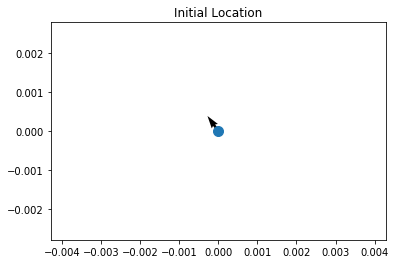

In [14]:
# Initial state
x = np.matrix([[mx[0], my[0], course[0]/180.0*np.pi, speed[0]/3.6+0.001, yawrate[0]/180.0*np.pi]]).T
print(x)

U = float(np.cos(x[2])*x[3])
V = float(np.sin(x[2])*x[3])

plt.quiver(x[0],x[1],U,V) #x0,x1 is the location, U & V are direction of the arrow
plt.scatter(float(x[0]), float(x[1]), s=100)
plt.title('Initial Location')
plt.axis('equal')


In [15]:
#Put everything together as a measurement vector
measurements = np.vstack((mx, my, speed/3.6, yawrate/180.0*np.pi))
# Lenth of the measurement
m = measurements.shape[1]
print(measurements.shape)

(4, 10800)


In [16]:
# Preallocation for Plotting
x0 = []
x1 = []
x2 = []
x3 = []
x4 = []
x5 = []
Zx = []
Zy = []
Px = []
Py = []
Pdx= []
Pdy= []
Pddx=[]
Pddy=[]
Kx = []
Ky = []
Kdx= []
Kdy= []
Kddx=[]
dstate=[]


def savestates(x, Z, P, K):
    x0.append(float(x[0]))
    x1.append(float(x[1]))
    x2.append(float(x[2]))
    x3.append(float(x[3]))
    x4.append(float(x[4]))
    Zx.append(float(Z[0]))
    Zy.append(float(Z[1]))    
    Px.append(float(P[0,0]))
    Py.append(float(P[1,1]))
    Pdx.append(float(P[2,2]))
    Pdy.append(float(P[3,3]))
    Pddx.append(float(P[4,4]))
    Kx.append(float(K[0,0]))
    Ky.append(float(K[1,0]))
    Kdx.append(float(K[2,0]))
    Kdy.append(float(K[3,0]))
    Kddx.append(float(K[4,0]))

### Main Extended Kalman Filter steps

In [17]:
for filterstep in range(m):
    if np.abs(yawrate[filterstep])<0.0001: #Driving straight, we can use this for a 1D case as well
        x[0]= x[0] + x[3]*dt*np.cos(x[2])
        x[1]= x[1] + x[3]*dt*np.sin(x[2])
        x[2]= x[2]
        x[3]= x[3]
        x[4]= 0.0000001 #just to avoid numerical issues in Jacobian
        dstate.append(0)
    else: #otherwise we have a yawrate measurement
        x[0] = x[0] + (x[3]/x[4]) * (np.sin(x[4]*dt+x[2]) - np.sin(x[2]))
        x[1] = x[1] + (x[3]/x[4]) * (-np.cos(x[4]*dt+x[2])+ np.cos(x[2]))
        x[2] = (x[2] + x[4]*dt + np.pi) % (2.0*np.pi) - np.pi
        x[3] = x[3]
        x[4] = x[4]
        dstate.append(1)
    
    #calculate the Jacobian of the Dynamic Matrix A. This is just copy from a previous cell
    a13 = float((x[3]/x[4]) * (np.cos(x[4]*dt+x[2]) - np.cos(x[2])))
    a14 = float((1.0/x[4]) * (np.sin(x[4]*dt+x[2]) - np.sin(x[2])))
    a15 = float((dt*x[3]/x[4])*np.cos(x[4]*dt+x[2]) - (x[3]/x[4]**2)*(np.sin(x[4]*dt+x[2]) - np.sin(x[2])))
    a23 = float((x[3]/x[4]) * (np.sin(x[4]*dt+x[2]) - np.sin(x[2])))
    a24 = float((1.0/x[4]) * (-np.cos(x[4]*dt+x[2]) + np.cos(x[2])))
    a25 = float((dt*x[3]/x[4])*np.sin(x[4]*dt+x[2]) - (x[3]/x[4]**2)*(-np.cos(x[4]*dt+x[2]) + np.cos(x[2])))
    JA = np.matrix([[1.0, 0.0, a13, a14, a15],
                    [0.0, 1.0, a23, a24, a25],
                    [0.0, 0.0, 1.0, 0.0, dt],
                    [0.0, 0.0, 0.0, 1.0, 0.0],
                    [0.0, 0.0, 0.0, 0.0, 1.0]])
    
    # Project the error covariance ahead
    P = JA *P* JA.T + Q
    #measurement function
    hx = np.matrix([[float(x[0])],[float(x[1])],[float(x[3])],[float(x[4])]])
    
    if GPS[filterstep]: # with 10Hz, every 5th step
        JH = np.matrix([[1.0, 0.0, 0.0, 0.0, 0.0],
                        [0.0, 1.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 1.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 1.0]])
    else: # every other step, only update heading and yawrate
        JH = np.matrix([[0.0, 0.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 1.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 1.0]])    
    S = JH*P*JH.T + R
    K = (P*JH.T) * np.linalg.inv(S)

    # Update the estimate via
    Z = measurements[:,filterstep].reshape(JH.shape[0],1)
    y = Z - (hx)                         # Innovation or Residual
    x = x + (K*y)

    # Update the error covariance
    P = (I - (K*JH))*P


    
    # Save states for Plotting
    savestates(x, Z, P, K)    

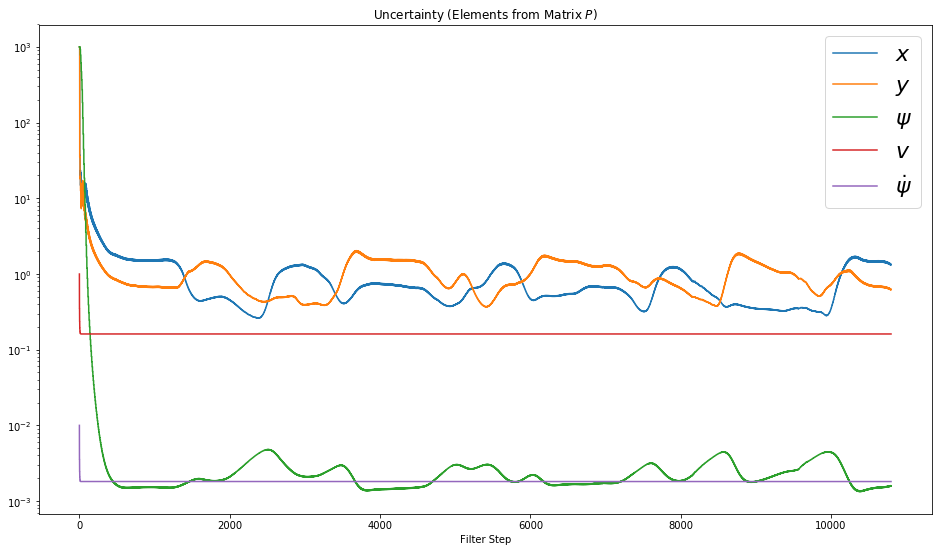

In [18]:
# now plot the filter performance
def plotP():
    fig = plt.figure(figsize=(16,9))
    plt.semilogy(range(m),Px, label='$x$')
    plt.step(range(m),Py, label='$y$')
    plt.step(range(m),Pdx, label='$\psi$')
    plt.step(range(m),Pdy, label='$v$')
    plt.step(range(m),Pddx, label='$\dot \psi$')

    plt.xlabel('Filter Step')
    plt.ylabel('')
    plt.title('Uncertainty (Elements from Matrix $P$)')
    plt.legend(loc='best',prop={'size':22})
plotP()

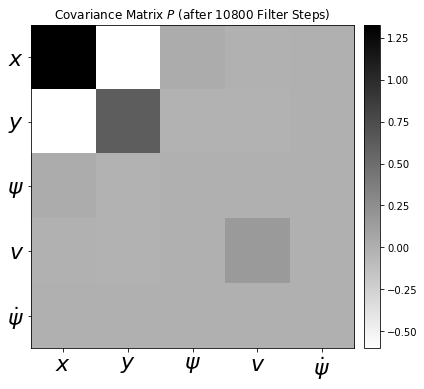

In [19]:
#Covariance matrix P
fig = plt.figure(figsize=(6, 6))
im = plt.imshow(P, interpolation="none", cmap=plt.get_cmap('binary'))
plt.title('Covariance Matrix $P$ (after %i Filter Steps)' % (m))
ylocs, ylabels = plt.yticks()
# set the locations of the yticks
plt.yticks(np.arange(6))
# set the locations and labels of the yticks
plt.yticks(np.arange(5),('$x$', '$y$', '$\psi$', '$v$', '$\dot \psi$'), fontsize=22)

xlocs, xlabels = plt.xticks()
# set the locations of the yticks
plt.xticks(np.arange(6))
# set the locations and labels of the yticks
plt.xticks(np.arange(5),('$x$', '$y$', '$\psi$', '$v$', '$\dot \psi$'), fontsize=22)

plt.xlim([-0.5,4.5])
plt.ylim([4.5, -0.5])

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)


plt.tight_layout()

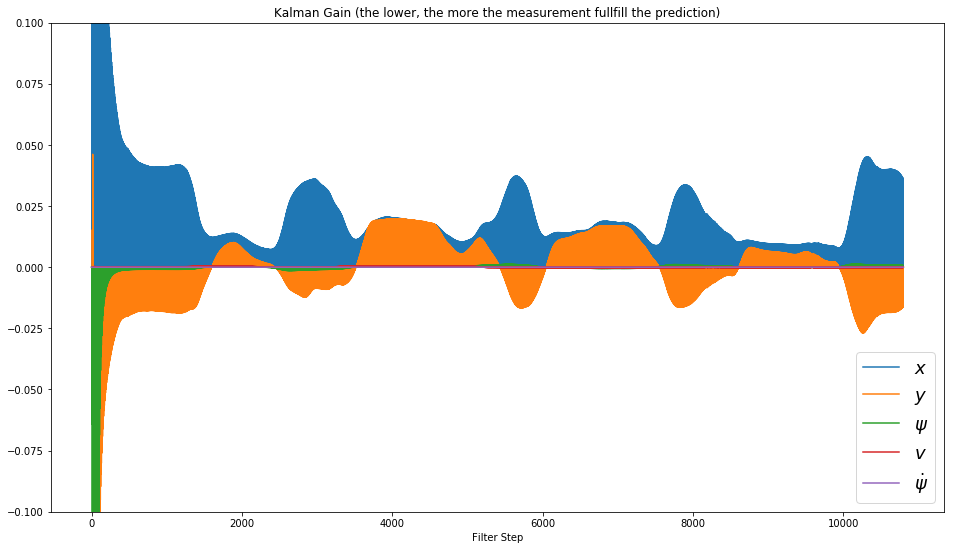

In [20]:
#Kalman gain
fig = plt.figure(figsize=(16,9))
plt.step(range(len(measurements[0])),Kx, label='$x$')
plt.step(range(len(measurements[0])),Ky, label='$y$')
plt.step(range(len(measurements[0])),Kdx, label='$\psi$')
plt.step(range(len(measurements[0])),Kdy, label='$v$')
plt.step(range(len(measurements[0])),Kddx, label='$\dot \psi$')


plt.xlabel('Filter Step')
plt.ylabel('')
plt.title('Kalman Gain (the lower, the more the measurement fullfill the prediction)')
plt.legend(prop={'size':18})
plt.ylim([-0.1,0.1]);

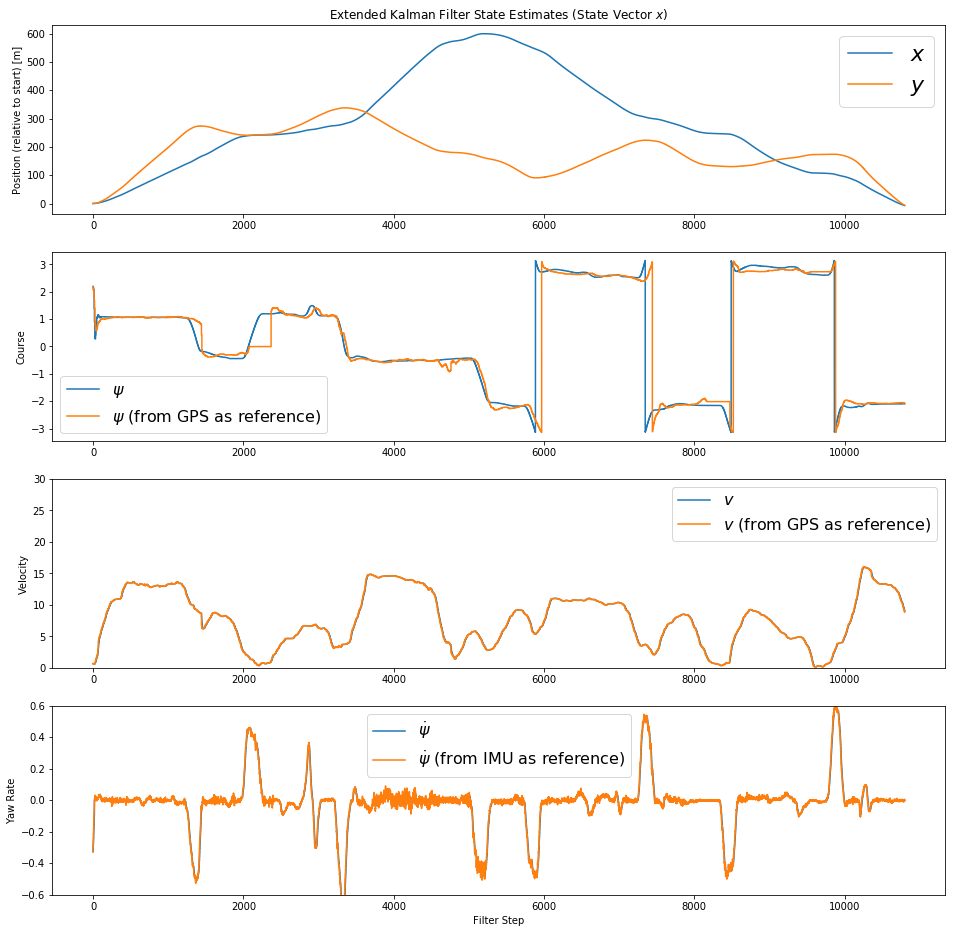

In [21]:
#State vector
def plotx():
    fig = plt.figure(figsize=(16,16))

    plt.subplot(411)
    plt.step(range(len(measurements[0])),x0-mx[0], label='$x$')
    plt.step(range(len(measurements[0])),x1-my[0], label='$y$')

    plt.title('Extended Kalman Filter State Estimates (State Vector $x$)')
    plt.legend(loc='best',prop={'size':22})
    plt.ylabel('Position (relative to start) [m]')

    plt.subplot(412)
    plt.step(range(len(measurements[0])),x2, label='$\psi$')
    plt.step(range(len(measurements[0])),(course/180.0*np.pi+np.pi)%(2.0*np.pi) - np.pi, label='$\psi$ (from GPS as reference)')
    plt.ylabel('Course')
    plt.legend(loc='best',prop={'size':16})

    plt.subplot(413)
    plt.step(range(len(measurements[0])),x3, label='$v$')
    plt.step(range(len(measurements[0])),speed/3.6, label='$v$ (from GPS as reference)')
    plt.ylabel('Velocity')
    plt.ylim([0, 30])
    plt.legend(loc='best',prop={'size':16})

    plt.subplot(414)
    plt.step(range(len(measurements[0])),x4, label='$\dot \psi$')
    plt.step(range(len(measurements[0])),yawrate/180.0*np.pi, label='$\dot \psi$ (from IMU as reference)')
    plt.ylabel('Yaw Rate')
    plt.ylim([-0.6, 0.6])
    plt.legend(loc='best',prop={'size':16})
    plt.xlabel('Filter Step')

    plt.savefig('Extended-Kalman-Filter-CTRV-State-Estimates.png', dpi=72, transparent=True, bbox_inches='tight')
plotx()

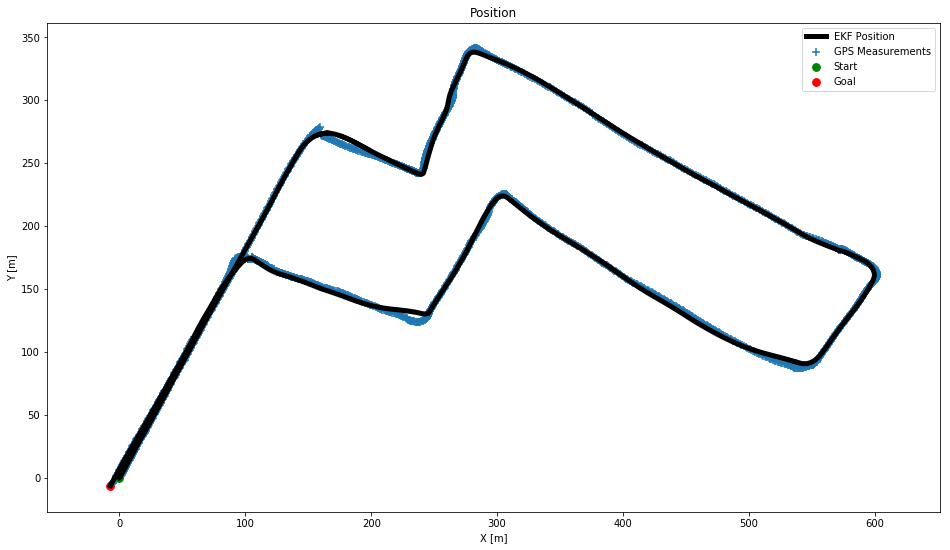

In [22]:
#plotxy
def plotxy():

    fig = plt.figure(figsize=(16,9))

    # EKF State
    plt.quiver(x0,x1,np.cos(x2), np.sin(x2), color='#94C600', units='xy', width=0.05, scale=0.5)
    plt.plot(x0,x1, label='EKF Position', c='k', lw=5)

    # Measurements
    plt.scatter(mx[::5],my[::5], s=50, label='GPS Measurements', marker='+')
    #cbar=plt.colorbar(ticks=np.arange(20))
    #cbar.ax.set_ylabel(u'EPE', rotation=270)
    #cbar.ax.set_xlabel(u'm')

    # Start/Goal
    plt.scatter(x0[0],x1[0], s=60, label='Start', c='g')
    plt.scatter(x0[-1],x1[-1], s=60, label='Goal', c='r')

    plt.xlabel('X [m]')
    plt.ylabel('Y [m]')
    plt.title('Position')
    plt.legend(loc='best')
    plt.axis('equal')
    #plt.tight_layout()

    #plt.savefig('Extended-Kalman-Filter-CTRV-Position.png', dpi=72, transparent=True, bbox_inches='tight')
plotxy()    

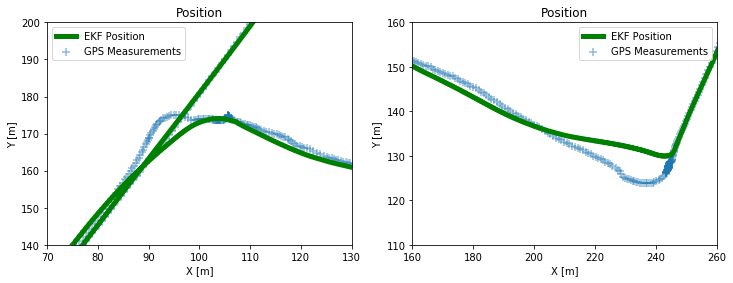

In [23]:
#Detailed xy view
def plotxydetails():
    fig = plt.figure(figsize=(12,9))

    plt.subplot(221)
    # EKF State
    #plt.quiver(x0,x1,np.cos(x2), np.sin(x2), color='#94C600', units='xy', width=0.05, scale=0.5)
    plt.plot(x0,x1, label='EKF Position', c='g', lw=5)

    # Measurements
    plt.scatter(mx[::5],my[::5], s=50, label='GPS Measurements', alpha=0.5, marker='+')
    #cbar=plt.colorbar(ticks=np.arange(20))
    #cbar.ax.set_ylabel(u'EPE', rotation=270)
    #cbar.ax.set_xlabel(u'm')

    plt.xlabel('X [m]')
    plt.xlim(70, 130)
    plt.ylabel('Y [m]')
    plt.ylim(140, 200)
    plt.title('Position')
    plt.legend(loc='best')


    plt.subplot(222)

    # EKF State
    #plt.quiver(x0,x1,np.cos(x2), np.sin(x2), color='#94C600', units='xy', width=0.05, scale=0.5)
    plt.plot(x0,x1, label='EKF Position', c='g', lw=5)

    # Measurements
    plt.scatter(mx[::5],my[::5], s=50, label='GPS Measurements', alpha=0.5, marker='+')
    #cbar=plt.colorbar(ticks=np.arange(20))
    #cbar.ax.set_ylabel(u'EPE', rotation=270)
    #cbar.ax.set_xlabel(u'm')

    plt.xlabel('X [m]')
    plt.xlim(160, 260)
    plt.ylabel('Y [m]')
    plt.ylim(110, 160)
    plt.title('Position')
    plt.legend(loc='best')
    
plotxydetails()